# 02 Build In-Person Day-Level Data

In [76]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
pd.set_option("display.max_columns", 120)


In [77]:
from pathlib import Path

def detect_csvs(project_root=Path("..")):
    cand_roots = [project_root, project_root/"data", Path("."), Path("..")]
    names = {
        "tran": "dcpc_2024_tranlevel_public.csv",
        "day" : "dcpc_2024_daylevel_public.csv",
        "ind" : "dcpc_2024_indlevel_public.csv",
    }
    paths = {}
    for k, fn in names.items():
        found = None
        for r in cand_roots:
            p = (r/fn)
            if p.exists():
                found = p.resolve(); break
        if found is None:
            p = project_root/"data"/fn
            if p.exists(): found = p.resolve()
        paths[k] = found
    return paths

paths = detect_csvs(Path(".."))
pprint(paths)
assert paths["tran"] is not None, "TRAN csv not found; put it under ../data/ or project root."
tran_path = paths["tran"]
tran_path


{'day': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_daylevel_public.csv'),
 'ind': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_indlevel_public.csv'),
 'tran': WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_tranlevel_public.csv')}


WindowsPath('C:/Users/Kaiyan Zhang/Desktop/dcpc-friction-dml/data/dcpc_2024_tranlevel_public.csv')

In [78]:
# Load transaction-level data
tran = pd.read_csv(tran_path, low_memory=False)

def pick(df, opts):
    for c in opts:
        if c in df.columns: return c
    return None

ID_COLS  = ["_id","id","person_id","PID"]
DATE_COL = ["_date","date"]
AMT_COL  = ["_amount","amount","amnt"]

id_col   = pick(tran, ID_COLS)
date_col = pick(tran, DATE_COL)
amt_col  = pick(tran, AMT_COL)

print("Using columns:", {"id":id_col, "date":date_col, "amount":amt_col})

tran[id_col]   = pd.to_numeric(tran[id_col], errors="coerce")
tran[date_col] = pd.to_datetime(tran[date_col], errors="coerce")
tran[amt_col]  = pd.to_numeric(tran[amt_col], errors="coerce")

print("Shape:", tran.shape)
tran.head(3)


Using columns: {'id': 'id', 'date': 'date', 'amount': 'amnt'}
Shape: (32267, 67)


,id,old_diary_day,date,tran,tran_report,amnt_orig,payamnt_erramnt,pi,amnt,amnt_flag,merch,cc_surcharge,q101ee,device,time,in_person,diary_day,mobile_method,authorization_method,pay010,pay011,pay082,p2p_type,p2p_business,ccbaldue,enough_cash,accept_cash,accept_card,dc_rewards,used_rewards_cc,used_revolve_cc,cc_discount,prepaid_logo,mobile_funding,mobile_app,monord_source,monord_date,why_multipi,billautom,bill,payee,multipi_breakdown,discount,tran_min,paylocaltime,payment,module,start_date,nonpaymenttran,cashdepmethod,cashdeptime,cashdepaccount,chkdepfunds,cashgetlocation,cashgetsource,cashgetfee,cashgettime,chktransferaccount,chktransferfee,chktransferwhenrec,chktransferinstitution,q211paymeth,uncommon_pi_type,prepaidloadmethod,prepaidloadlocation,prepaidloadfee,transaction_reported_on_day
0,103858,1,2024-09-29,1,1.0,50.0,NaN,2.0,50.0,NaN,17.0,NaN,NaN,7.0,12:00 AM,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,104674,1,2024-09-29,1,1.0,8.0,NaN,11.0,8.0,NaN,15.0,NaN,NaN,1.0,12:00 AM,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,101352,1,2024-09-29,1,1.0,5.0,NaN,4.0,5.0,NaN,1.0,NaN,2.0,7.0,12:00 AM,1.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,0.0,0.0,00:00,1,bills_purchases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In-person value counts:
in_person
 1.0    17891
 0.0    10897
 NaN     3478
-1.0        1
Name: count, dtype: int64


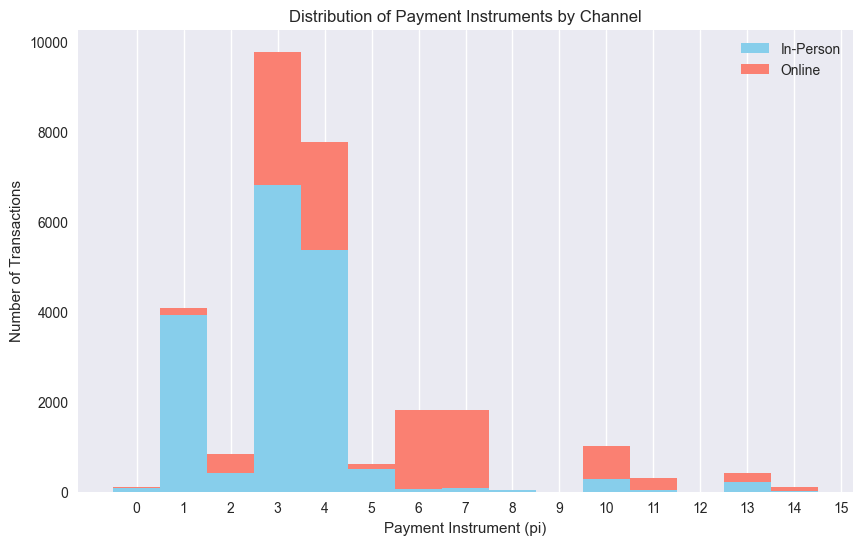

In [79]:
# Investigate the online vs in-person breakdown
# Plot pi distribution for online vs in-person transactions
# Stack by low vs high friction within each channel

in_person_counts = tran["in_person"].value_counts(dropna=False)
print("In-person value counts:")
print(in_person_counts) 

# Plot distribution of pi by in_person
plt.figure(figsize=(10, 6))
pi_inperson = tran[tran["in_person"] == 1]["pi"]
pi_online   = tran[tran["in_person"] == 0]["pi"]

plt.hist([pi_inperson, pi_online], bins=np.arange(0, 16)-0.5, stacked=True, label=['In-Person', 'Online'], color=['skyblue', 'salmon'])
plt.xticks(range(0, 16))
plt.xlabel('Payment Instrument (pi)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Payment Instruments by Channel')
plt.legend()
plt.grid(axis='y')
plt.show()

- 0- Multiple payment methods 
- 1- Cash 
- 2- Check 
- 3- Credit card 
- 4- Debit card 
- 5- Prepaid/gift/EBT card 
- 6- Bank account number payment 
- 7- Online banking bill payment 
- 8- Money order 
- 9- Traveler’s check 
- 10- Mobile payment apps 
- 11- Account-to-account transfer
- 12- Mobile phone payment 
- 13- Other payment method 
- 14- Deduction from income

In [80]:
# Keep only payment transactions
is_payment = (tran.get("payment", 1) == 1) & (tran.get("nonpaymenttran").isna())
tx = tran[is_payment].copy()

# Force pi to numeric
if "pi" not in tx.columns:
    raise ValueError("'pi' column not found in transaction data.")
tx["pi"] = pd.to_numeric(tx["pi"], errors="coerce")

# Define STRICT filtering sets
STRICT_LOW  = {3, 4, 5, 10}      # low-friction: Credit Card/ACH/Wallet/Bank Online
STRICT_HIGH = {1, 2}         # high-friction: Cash/Cashier's Check/Money Order
STRICT_KEEP = STRICT_LOW | STRICT_HIGH
STRICT_DROP = {0,11,6,7,8,9,11, 12, 13, 14}  # Drop the rest


In [81]:
# Drop transactions with pi not in STRICT_KEEP
before = len(tx)
tx_strict = tx[tx["pi"].isin(STRICT_KEEP)].copy()
dropped = before - len(tx_strict) + tx_strict["pi"].isna().sum()  # include NaN
print(f"[STRICT] Before: {before:,}  After: {len(tx_strict):,}  Dropped (incl. NaN & others): {before - len(tx_strict):,}")

# Create low_friction_txn indicator
tx_strict["low_friction_txn"] = np.where(tx_strict["pi"].isin(STRICT_LOW), 1, 0).astype(int)

# Check results
print("\n[STRICT] PI value counts kept:")
print(tx_strict["pi"].value_counts(dropna=False).sort_index())
print("\n[STRICT] low_friction_txn share:", round(tx_strict["low_friction_txn"].mean(), 4))

# Keep the STRICT filtered data
tx = tx_strict


[STRICT] Before: 28,810  After: 24,081  Dropped (incl. NaN & others): 4,729

[STRICT] PI value counts kept:
pi
1.0     4082
2.0      829
3.0     9777
4.0     7768
5.0      617
10.0    1008
Name: count, dtype: int64

[STRICT] low_friction_txn share: 0.7961


In-person value counts:
in_person
1.0    17310
0.0     6761
NaN       10
Name: count, dtype: int64


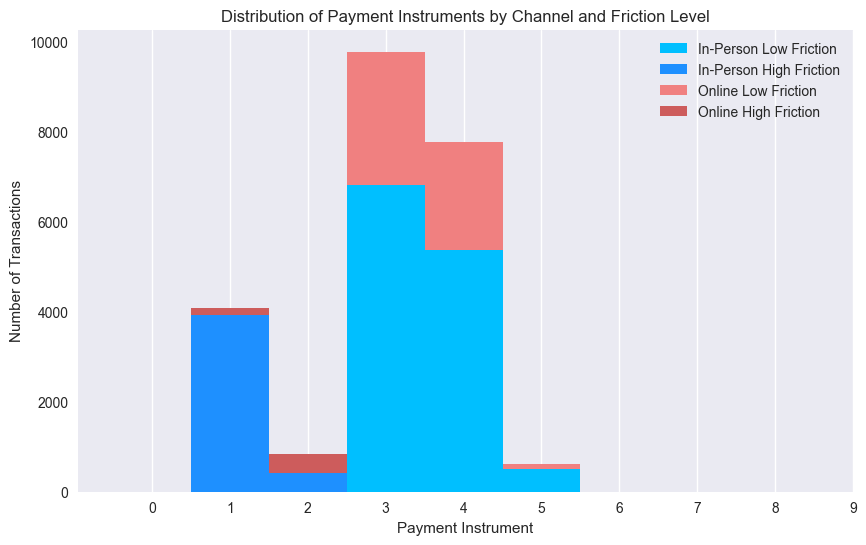

In [82]:
# Investigate the online vs in-person breakdown
# Plot pi distribution for online vs in-person transactions
# Stack by low vs high friction within each channel

in_person_counts = tx["in_person"].value_counts(dropna=False)
print("In-person value counts:")
print(in_person_counts) 

# Plot distribution of pi by in_person
# Color by low vs high friction
plt.figure(figsize=(10, 6))
pi_inperson_low  = tx[(tx["in_person"] == 1) & (tx["low_friction_txn"] == 1)]["pi"]
pi_inperson_high = tx[(tx["in_person"] == 1) & (tx["low_friction_txn"] == 0)]["pi"]
pi_online_low    = tx[(tx["in_person"] == 0) & (tx["low_friction_txn"] == 1)]["pi"]
pi_online_high   = tx[(tx["in_person"] == 0) & (tx["low_friction_txn"] == 0)]["pi"]

plt.hist([pi_inperson_low, pi_inperson_high, pi_online_low, pi_online_high], 
         bins=np.arange(0, 10)-0.5, stacked=True, 
         label=['In-Person Low Friction', 'In-Person High Friction', 'Online Low Friction', 'Online High Friction'], 
            color=['deepskyblue', 'dodgerblue', 'lightcoral', 'indianred'])

plt.xticks(range(0, 10))
plt.xlabel('Payment Instrument')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Payment Instruments by Channel and Friction Level')
plt.legend()
plt.grid(axis='y')
plt.show()

Keep only in-person payment transactions

In [83]:
tx["_inperson"] = pd.to_numeric(tx.get("in_person"), errors="coerce")
tx_ip = tx[tx["_inperson"] == 1].copy()
print("In-person transactions:", tx_ip.shape)

In-person transactions: (17310, 69)


In [84]:
# Count in-person low-friction share
low_friction_share = tx_ip["low_friction_txn"].mean()
print("In-person low-friction transaction share:", round(low_friction_share, 4))

In-person low-friction transaction share: 0.7491


Integrate to the individual-day level

In [85]:
g = tx_ip.groupby([id_col, date_col], as_index=False)

# Aggregate by sum amount, count tx, sum low_friction_txn
day_ip = g.agg(
    day_total_amount=(amt_col, "sum"),
    n_tx=(amt_col, "size"),
    n_low_tx=("low_friction_txn", "sum"),
)

# 
day_ip = day_ip.rename(columns={id_col:"_id", date_col:"_date"})
day_ip["T_share_low"] = (day_ip["n_low_tx"] / day_ip["n_tx"]).fillna(0.0)
day_ip["Y_log_amt"]   = np.log1p(day_ip["day_total_amount"])
day_ip["_weekday"]    = pd.to_datetime(day_ip["_date"]).dt.weekday

day_ip.head(3)


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6


Merchant Basket Analysis

In [86]:
if "merch" in tx_ip.columns:
    vc = tx_ip["merch"].value_counts()
    # pick top-20 safely
    top_merch = vc.nlargest(20) if hasattr(vc, "nlargest") else vc.head(20)
    top_merch = list(top_merch.index)

    piv = (tx_ip.assign(one=1)
                 .query("merch in @top_merch")
                 .pivot_table(index=[id_col, date_col], columns="merch", values="one",
                              aggfunc="sum", fill_value=0))
    # make pivot index names match day_ip ('_id','_date') so merge with right_index=True works
    piv.index.names = ["_id", "_date"]
    piv = piv.div(piv.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    piv.columns = [f"mshare_{int(c)}" for c in piv.columns]
    day_ip = day_ip.merge(piv, left_on=["_id","_date"], right_index=True, how="left").fillna(0.0)

X_cols = ["_weekday"] + [c for c in day_ip.columns if str(c).startswith("mshare_")]
print("#X columns:", len(X_cols))
day_ip.head(3)


#X columns: 21


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday,mshare_1,mshare_2,mshare_3,mshare_4,mshare_5,mshare_6,mshare_7,mshare_8,mshare_9,mshare_10,mshare_12,mshare_13,mshare_14,mshare_15,mshare_16,mshare_17,mshare_18,mshare_19,mshare_20,mshare_21
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# Trim T_share_low to avoid extreme propensity scores
day_ip["T_share_low_trim"] = day_ip["T_share_low"].clip(0.05, 0.95)

# weight by daily active persons
active = (day_ip.groupby("_date").agg(active_persons=("_id","nunique")).reset_index())
w_day  = (active["active_persons"] / active["active_persons"].mean()).clip(0.2, 2.0)
day_ip = day_ip.merge(active.assign(w_day=w_day), on="_date", how="left")

day_ip.shape, day_ip[["T_share_low","T_share_low_trim","Y_log_amt","w_day"]].describe()


((8445, 31),
        T_share_low  T_share_low_trim    Y_log_amt        w_day
 count  8445.000000       8445.000000  8445.000000  8445.000000
 mean      0.739102          0.716308     3.913106     1.169209
 std       0.391547          0.353060     1.300164     0.179698
 min       0.000000          0.050000    -0.235722     0.200000
 25%       0.500000          0.500000     3.044522     1.122558
 50%       1.000000          0.950000     3.931826     1.217288
 75%       1.000000          0.950000     4.732243     1.264654
 max       1.000000          0.950000    10.312128     1.383067)

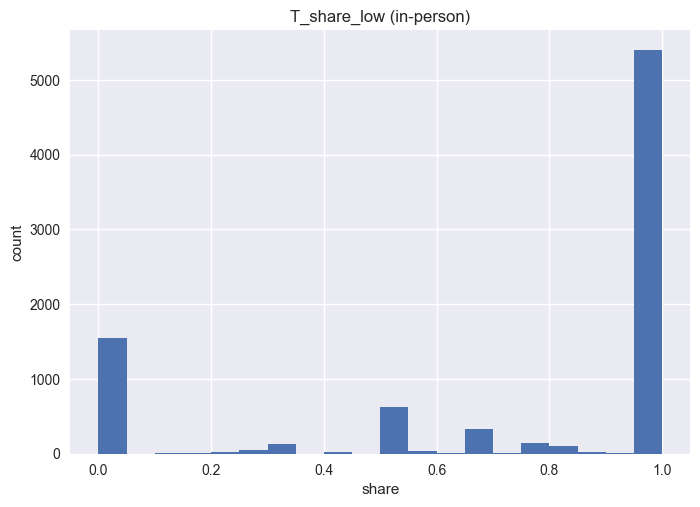

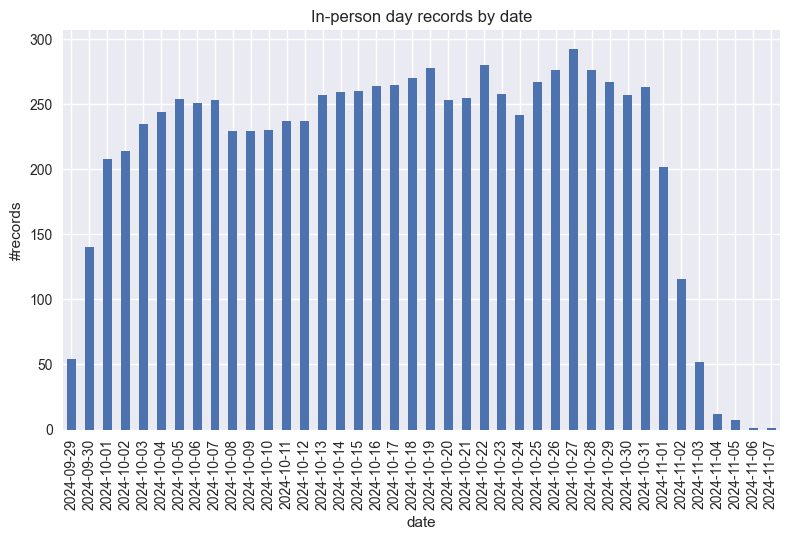

In [88]:
plt.figure()
plt.hist(day_ip["T_share_low"], bins=20)
plt.title("T_share_low (in-person)")
plt.xlabel("share"); plt.ylabel("count")
plt.show()

plt.figure()
day_ip["_date"].dt.date.value_counts().sort_index().plot(kind="bar")
plt.title("In-person day records by date")
plt.xlabel("date"); plt.ylabel("#records")
plt.tight_layout(); plt.show()


In [89]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

# Using day_ip from above
mcols = [c for c in day_ip.columns if c.startswith("mshare_")]
daily_avg = (
    day_ip
    .groupby("_date")[mcols]
    .mean()
    .sort_index()
)

# Rename columns to full category names
daily_avg_renamed = daily_avg.rename(columns={
    'mshare_1': "Grocery stores, convenience stores & pharmacies",
    'mshare_2': "Gas stations",
    'mshare_3': "Sit-down restaurants and bars",
    'mshare_4': "Fast food restaurants, coffee shops, etc.",
    'mshare_5': "General merchandise stores and online shopping",
    'mshare_6': "General services",
    'mshare_7': "Arts, entertainment, recreation",
    'mshare_8': "Utilities not paid to the government",
    'mshare_9': "Taxis, airplanes, delivery",
    'mshare_10': "Telephone, internet, cable or satellite TV",
    'mshare_11': "Building contractors, plumbers, electricians, etc.",
    'mshare_12': "Professional services",
    'mshare_13': "Hotels, motels, RV parks, campsites",
    'mshare_14': "Rent for apartments, homes, or other buildings",
    'mshare_15': "Mortgage, credit card companies, banks, insurance",
    'mshare_16': "Gift or repayment to a family member, friend, or co-worker",
    'mshare_17': "Charitable or religious donations",
    'mshare_18': "Hospital, doctor, dentist",
    'mshare_19': "Government taxes or fees",
    'mshare_20': "Schools, colleges, childcare centers",
    'mshare_21': "Public transportation and tolls",
})

# Calculate overall average shares to determine Top-K categories
avg_shares_all = daily_avg_renamed.mean().sort_values(ascending=False)

TOP_K = 10
top_cats = avg_shares_all.index[:TOP_K]
other_cats = avg_shares_all.index[TOP_K:]

daily_top = daily_avg_renamed[top_cats].copy()
if len(other_cats) > 0:
    daily_top["Other categories"] = daily_avg_renamed[other_cats].sum(axis=1)

# Sort categories by overall average share again for consistent ordering
avg_shares = daily_top.mean().sort_values(ascending=False)
ordered_cats = avg_shares.index.tolist()
daily_top = daily_top[ordered_cats]

# Matching colors
cmap = cm.get_cmap("tab20", len(ordered_cats))
color_dict = {cat: cmap(i) for i, cat in enumerate(ordered_cats)}


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_28852\3392327613.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(ordered_cats))


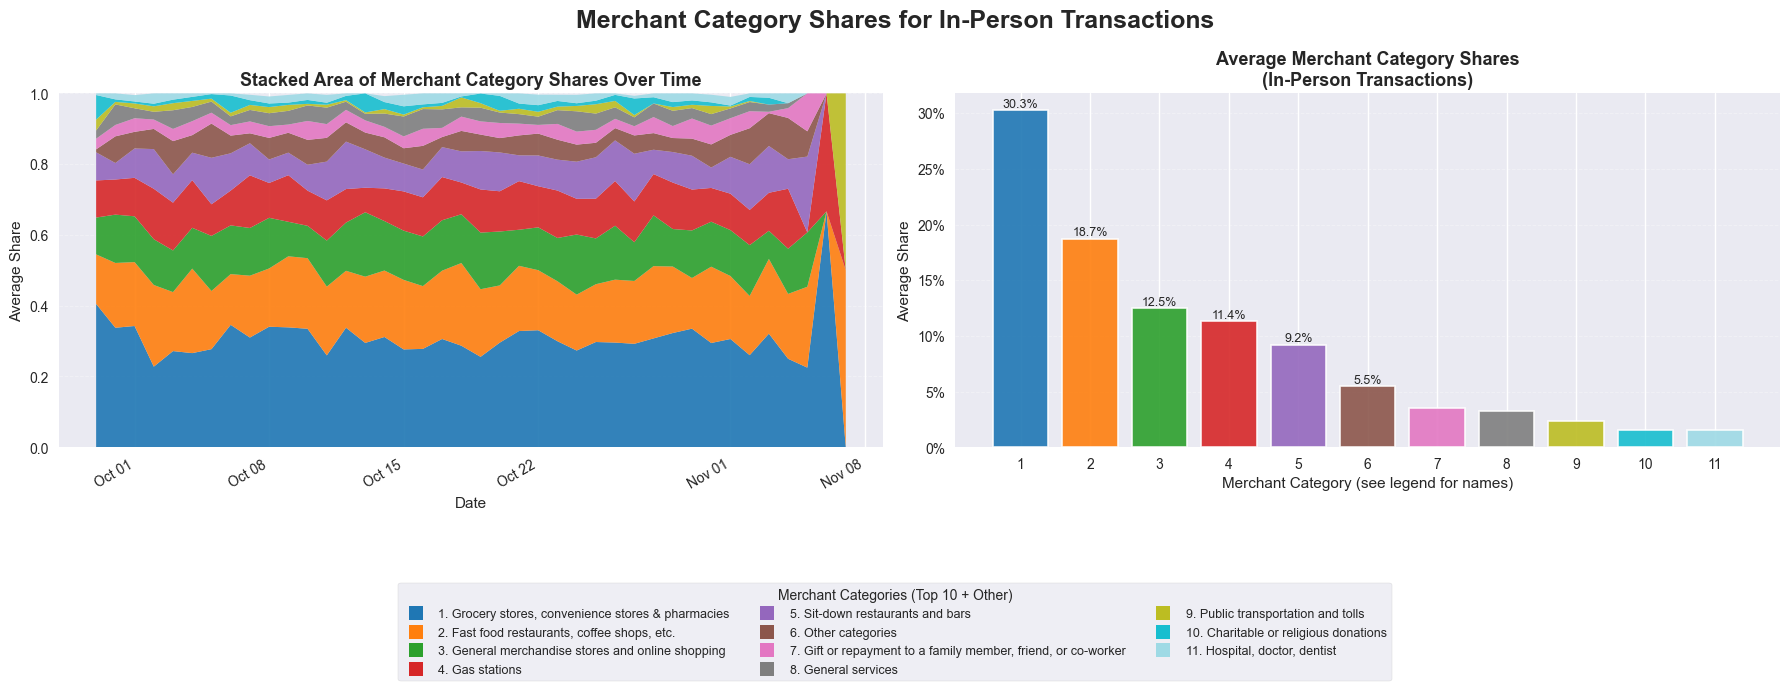

In [101]:

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Merchant Category Shares for In-Person Transactions", fontsize=18, fontweight="bold")


ax1.stackplot(
    daily_top.index,
    [daily_top[c].values for c in ordered_cats],
    labels=ordered_cats,
    colors=[color_dict[c] for c in ordered_cats],
    alpha=0.9
)

ax1.set_ylim(0, 1)
ax1.set_ylabel("Average Share", fontsize=11)
ax1.set_xlabel("Date", fontsize=11)
ax1.set_title("Stacked Area of Merchant Category Shares Over Time", fontsize=13, fontweight="bold")
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_axisbelow(True)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right')

bars = ax2.bar(
    range(len(ordered_cats)),
    avg_shares.values,
    color=[color_dict[c] for c in ordered_cats],
    edgecolor='white',
    linewidth=1.2,
    alpha=0.9
)

ax2.set_title("Average Merchant Category Shares\n(In-Person Transactions)", fontsize=13, fontweight="bold")
ax2.set_ylabel("Average Share", fontsize=11)
ax2.set_xticks(range(len(ordered_cats)))
# Only short labels on x-axis, full names in legend
short_labels = [f"{i+1}" for i in range(len(ordered_cats))]
ax2.set_xticklabels(short_labels)
ax2.set_xlabel("Merchant Category (see legend for names)", fontsize=11)

# % on y-axis
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax2.set_axisbelow(True)

for bar, val in zip(bars, avg_shares.values):
    if val > 0.05:
        ax2.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{val:.1%}",
            ha='center', va='bottom', fontsize=9
        )

# Legend: full category names + colors
legend_handles = [
    plt.Line2D([0], [0], marker='s', linestyle='',
               color=color_dict[c], markersize=10)
    for c in ordered_cats
]

fig.legend(
    legend_handles,
    [f"{i+1}. {name}" for i, name in enumerate(ordered_cats)],
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.15),
    fontsize=9,
    frameon=True,
    title="Merchant Categories (Top 10 + Other)",
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  
plt.show()

In [91]:
# Keep only the October data
day_ip = day_ip[day_ip["_date"].dt.month == 10].copy()

In [92]:
out = Path("..")/"outputs"/"day_inperson_ready.csv"
day_ip.to_csv(out, index=False)
print("Saved:", out)


Saved: ..\outputs\day_inperson_ready.csv


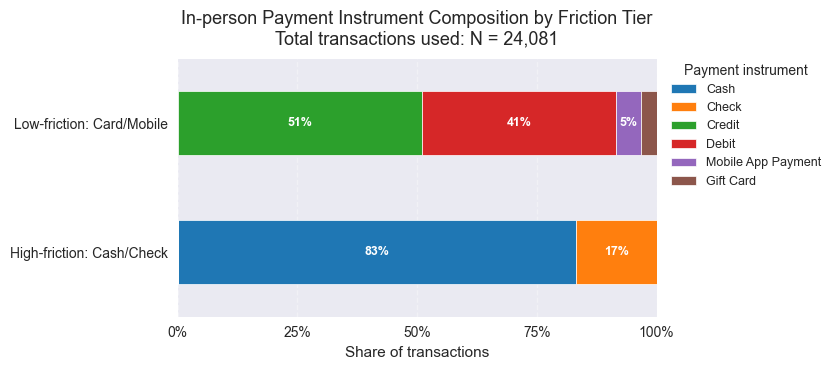


Records used: 24081
Tier counts: {0: 4911, 2: 19170}
Tier counts (labeled): {'High-friction: Cash/Check': 4911, 'Low-friction: Card/Mobile': 19170}


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---- path (robust to missing `tran_path`) ----
try:
    TRAN_PATH = tran_path
except NameError:
    TRAN_PATH = "transactions.csv"  # <- change this if needed

# ---- switches ----
IN_PERSON_ONLY = False  # True → 只看 in_person==1 的线下样本
LOW  = STRICT_LOW     # credit/debit/ACH/OBBP
HIGH = STRICT_HIGH
KEEP = LOW | HIGH

pi_labels = {
    1: "Cash", 2: "Check", 5: "Gift Card",
    3: "Credit", 4: "Debit", 10: "Mobile App Payment"
    }
# 为了图例排序更友好，按下面顺序显示
plot_order = ["Cash", "Check", "Credit", "Debit", "Mobile App Payment", "Gift Card"]

# Friction tier → human-readable label
tier_labels = {
    0: "High-friction: Cash/Check",
    2: "Low-friction: Card/Mobile",
}

# ---- load & basic filter ----
try:
    df = tx_strict.copy()
except NameError:
    df = pd.read_csv(TRAN_PATH, low_memory=False)

def pick(df, opts):
    for c in opts:
        if c in df.columns:
            return c
    return None

id_col   = pick(df, ["_id", "id", "person_id"])
date_col = pick(df, ["_date", "date"])
amt_col  = pick(df, ["_amount", "amnt", "amount"])

# 仅真实支付
is_payment = (df.get("payment", 1) == 1) & (df.get("nonpaymenttran").isna())
df = df[is_payment].copy()

# 只保留 pi 在 KEEP 的记录；将其余/缺失全部丢弃（最保守）
df["pi"] = pd.to_numeric(df.get("pi"), errors="coerce")
df = df[df["pi"].isin(KEEP)].copy()

# 可选：只看线下
if IN_PERSON_ONLY and "in_person" in df.columns:
    df = df[pd.to_numeric(df["in_person"], errors="coerce") == 1].copy()

# ---- friction_tier（严格只两档：0/2）----
df["friction_tier"] = np.where(df["pi"].isin(LOW), 2,
                         np.where(df["pi"].isin(HIGH), 0, np.nan))
df = df.dropna(subset=["friction_tier"]).copy()
df["friction_tier"] = df["friction_tier"].astype(int)

# 标签列
df["pi_label"] = df["pi"].map(pi_labels).fillna(df["pi"].astype(str))
df["tier_label"] = df["friction_tier"].map(tier_labels).fillna(
    df["friction_tier"].astype(str)
)

# =========================
# SHARES: build shares_plot
# =========================
# 行：friction tier；列：PI 类型；值：row-wise share
shares = (
    df.groupby(["tier_label", "pi_label"])
      .size()
      .groupby(level=0, group_keys=False)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

# 只保留需要的列，并按指定顺序排列
shares = shares[[c for c in plot_order if c in shares.columns]]

# Ensure row order corresponds to friction_tier 0 → 2
idx_order = [tier_labels[t] for t in sorted(df["friction_tier"].unique())]
shares_plot = shares.reindex(idx_order)

# ---- total and per-tier counts for annotation ----
total_N = len(df)
tier_counts_raw = df["friction_tier"].value_counts().sort_index().to_dict()
tier_counts_labeled = {
    tier_labels.get(k, str(k)): v for k, v in tier_counts_raw.items()
}

# ---- consistent color palette for PI types ----
base_colors = mpl.colormaps["tab10"]
pi_colors = {
    label: base_colors(i)
    for i, label in enumerate(shares_plot.columns)
}
color_list = [pi_colors[c] for c in shares_plot.columns]

plt.style.use("seaborn-v0_8")

# =========================
# SHARES: main + only plot
# =========================
fig, ax = plt.subplots(figsize=(8.5, 3.8))

shares_plot.plot(
    kind="barh",
    stacked=True,
    color=color_list,
    ax=ax,
    edgecolor="white",
    linewidth=0.5,
)

# Title also shows total N
ax.set_title(
    f"In-person Payment Instrument Composition by Friction Tier\n"
    f"Total transactions used: N = {total_N:,}",
    fontsize=13,
    pad=10,
)

ax.set_xlabel("Share of transactions", fontsize=11)
ax.set_ylabel("")
ax.set_xlim(0, 1)

# 0–100% ticks
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

# subtle grid
ax.grid(axis="x", linestyle="--", alpha=0.35)
ax.grid(axis="y", visible=False)

# annotate segment percentages (only if segment > 5%)
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0.05:
            ax.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{width*100:.0f}%",
                ha="center",
                va="center",
                fontsize=9,
                color="white",
                fontweight="bold",
            )

ax.legend(
    title="Payment instrument",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9,
    title_fontsize=10,
)

plt.tight_layout()
plt.show()

# ---- sanity prints ----
print("\nRecords used:", total_N)
print("Tier counts:", tier_counts_raw)
print("Tier counts (labeled):", tier_counts_labeled)


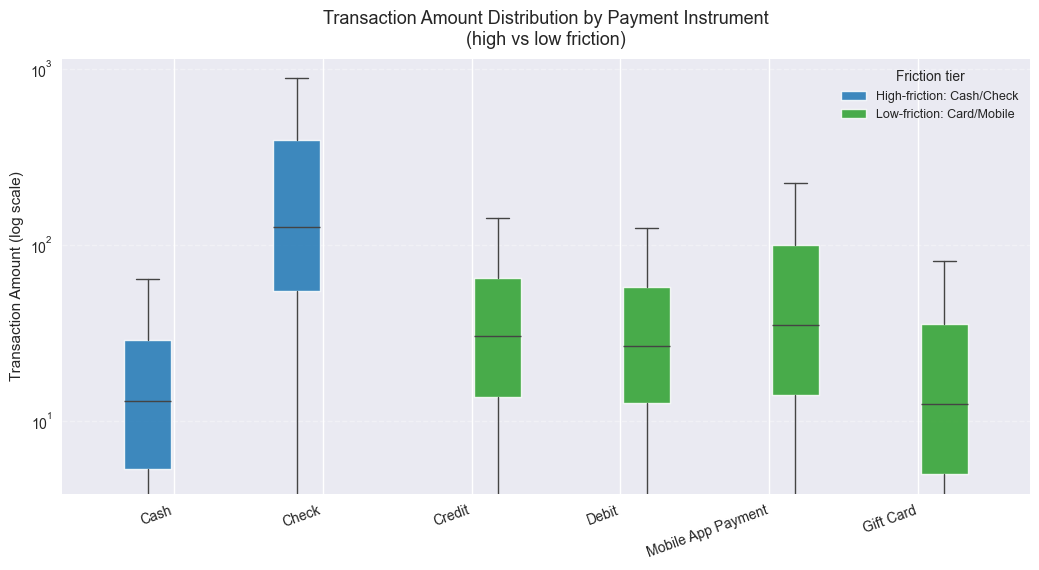

In [100]:
# Beautified boxplot: amounts by PI, colored by friction tier (high vs low)
# - keeps desired PI order
# - side-by-side boxes per PI (high vs low)
# - hide fliers; log-scale Y
# - cleaner grid and legend

cats = [c for c in plot_order if c in df["pi_label"].unique()]
tiers = [t for t in [tier_labels[0], tier_labels[2]] if t in df["tier_label"].unique()]

df_sub = df[df["pi_label"].isin(cats)].copy()

fig, ax = plt.subplots(figsize=(10.5, 5.8))

# consistent colors for tiers
base = mpl.colormaps["tab10"]
tier_colors = {
    tier_labels[0]: base(0),  # high friction
    tier_labels[2]: base(2),  # low friction
}

# positions: each PI has a center; tiers offset around it
centers = np.arange(len(cats))
width = 0.35
pos_map = {
    tier_labels[0]: centers - width/2,
    tier_labels[2]: centers + width/2,
}

# draw boxplots per tier
box_handles = []
for t in tiers:
    data = [df_sub.loc[df_sub["pi_label"].eq(c) & df_sub["tier_label"].eq(t), amt_col].dropna().values
            for c in cats]
    bp = ax.boxplot(
        data,
        positions=pos_map[t],
        widths=width*0.9,
        patch_artist=True,
        showfliers=False,
        whis=1.5,
        manage_ticks=False,
    )
    # style boxes
    for patch in bp["boxes"]:
        patch.set_facecolor(tier_colors[t])
        patch.set_edgecolor("white")
        patch.set_alpha(0.85)
    for element in ["whiskers", "caps", "medians"]:
        for item in bp[element]:
            item.set_color("#444")
            item.set_linewidth(1.0)
    box_handles.append((bp["boxes"][0], t))  # one handle per tier

ax.set_yscale("log")
ax.set_xlim(-0.75, len(cats)-0.25)
ax.set_xticks(centers)
ax.set_xticklabels(cats, rotation=20, ha="right")

ax.set_title("Transaction Amount Distribution by Payment Instrument\n(high vs low friction)", fontsize=13, pad=10)
ax.set_xlabel("")
ax.set_ylabel("Transaction Amount (log scale)", fontsize=11)
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.set_axisbelow(True)

# legend from tier handles
ax.legend(
    [h for h, _ in box_handles],
    [name for _, name in box_handles],
    title="Friction tier",
    loc="upper right",
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.show()
